In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

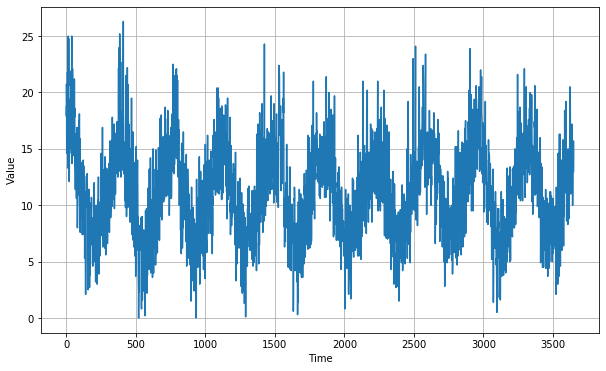

In [3]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset_1(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x : x.batch(window_size))
    dataset = dataset.shuffle(shuffle_buffer).map(dataset.map(lambda x : (x[:-1], x[-1])))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def windowed_dataset_2(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda x: [x[:-1], x[1:]])
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset_2(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 35ms/step - loss: 31.1571 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 31ms/step - loss: 30.5778 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.6825 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 28.5613 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 27.1974 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 25.5017 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 23.3464 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
 8/10 [=======================>......] - ETA: 0s - loss: 20.9580 - mae: 21.45410/10 [==============================] - 0s 25ms/step - loss: 20.6147 - mae: 21.1108 - lr: 2.2387e-08
Epoch 9/10